In [2]:
from datasets import load_from_disk
import re
from transformers import AutoTokenizer
from datasets import Dataset 
import torch

In [3]:
train_dataset = load_from_disk("/mnt/disk1/sumdev/NHAI_PROJECT/OTHER-THAN-NHAI/NLP-Project-Akshat/conv_data/therapy_train")
val_dataset = load_from_disk("/mnt/disk1/sumdev/NHAI_PROJECT/OTHER-THAN-NHAI/NLP-Project-Akshat/conv_data/therapy_val")
test_dataset = load_from_disk("/mnt/disk1/sumdev/NHAI_PROJECT/OTHER-THAN-NHAI/NLP-Project-Akshat/conv_data/therapy_test")

In [4]:

print(train_dataset)

print(train_dataset["target_text"])


print(train_dataset[0])


Dataset({
    features: ['input_text', 'target_text'],
    num_rows: 4008
})
["I'm doing well. Thanks for asking.", "So you're doing great.", "I know your brother brought you in today and he had expressed some concerns about your mood. Do you know what that's about?", "Alright, so you feel like, everything's kind of going your way. Hmm. And you're really excited about the new business idea. I know that your brother was a little concerned with how much you've been spending on the business idea. And he mentioned some things about different relationships you've had that are new.", "He's worried that you don't want to think this was the new relationship you don't know the guy too well", "So your brother just doesn't. In your mind, he just doesn't get it.", 'Have you noticed through all this, any change in sleep patterns?', "Notice you do feel rested. You haven't been sleeping as much.", "And you clearly seem like you're in a good mood No, no sadness right now at that,", 'should be doing pr

In [ ]:
with open("train_dataset_input_txt","w") as f:
    for line in range(len(train_dataset["input_text"])):
        # f.writelines
        f.writelines(train_dataset["input_text"][line])
        f.writelines("\n\n\n")

with open("train_dataset_target_txt","w") as f:
    for line in range(len(train_dataset["target_text"])):
        # f.writelines
        f.writelines(train_dataset["target_text"][line])
        f.writelines("\n\n\n")
    # f.write(train_dataset["input_text"])

In [5]:
from transformers import AutoTokenizer
from transformers import BartForConditionalGeneration, BartTokenizer


def lowercase(dataset):
    for i in range(len(dataset["input_text"])):
        dataset["input_text"][i] = dataset["input_text"][i].strip().lower()
        dataset["target_text"][i] = dataset["target_text"][i].strip().lower()
        dataset["input_text"][i] = re.sub(r'\s+', ' ', dataset["input_text"][i]).strip()
        dataset["target_text"][i] = re.sub(r'\s+', ' ', dataset["target_text"][i]).strip()
        # dataset["input_text"][i] = dataset["input_text"][i].replace('[SEP]', ' [SEP] ')
    return dataset

cleaned_train_Dataset = train_dataset.map(lowercase, batched = True)
cleaned_val_Dataset = val_dataset.map(lowercase, batched = True)
cleaned_test_Dataset = test_dataset.map(lowercase, batched = True)

# tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("t5-small")


# Load BART's pre-trained model and tokenizer
# model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
# tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")




tokenizer.add_special_tokens({'pad_token': '[PAD]'})


def tokenize_function(examples):
    # Tokenizing both input and target text
    input_data = tokenizer(examples['input_text'], truncation=True, padding=True, max_length=256)
    target_data = tokenizer(examples['target_text'], truncation=True, padding=True, max_length=256)
    
    # Convert the token IDs to subword tokens (lists of tokens)
    tokenized_input_tokens = [ tokenizer.convert_ids_to_tokens(ids) for ids in input_data["input_ids"]]
    tokenized_target_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in target_data["input_ids"]]
    
    # Return tokenized outputs along with additional original fields
    return {
        'input_ids': input_data['input_ids'],
        'attention_mask': input_data['attention_mask'],
        'labels': target_data['input_ids'], 
        'original_input_text': examples['input_text'],
        'original_target_text': examples['target_text'],
        'tokenized_input_text': tokenized_input_tokens,
        'tokenized_target_text': tokenized_target_tokens
    }


tokenized_train_dataset = cleaned_train_Dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = cleaned_val_Dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = cleaned_test_Dataset.map(tokenize_function, batched=True)

2025-04-15 08:03:20.214612: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 08:03:20.309974: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/disk1/sumdev/anaconda3/envs/nhai/lib/python3.9/site-packages/cv2/../../lib64:
2025-04-15 08:03:20.309996: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-04-15 08:03:20.824312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvi

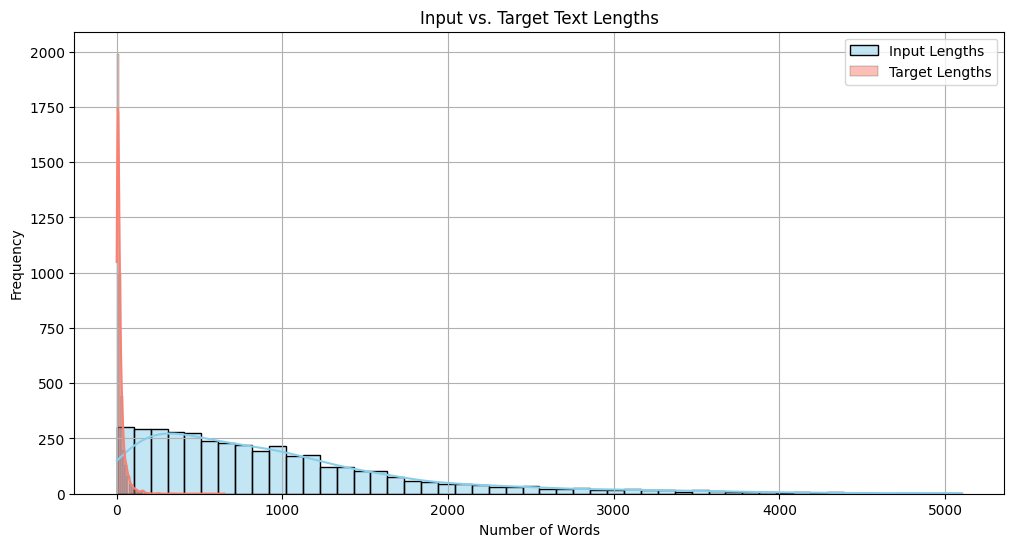

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate lengths
input_lengths = [len(text.split()) for text in train_dataset['input_text']]
target_lengths = [len(text.split()) for text in train_dataset['target_text']]

# Plot
plt.figure(figsize=(12, 6))
sns.histplot(input_lengths, bins=50, color='skyblue', label='Input Lengths', kde=True)
sns.histplot(target_lengths, bins=50, color='salmon', label='Target Lengths', kde=True)
plt.title('Input vs. Target Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/disk1/sumdev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


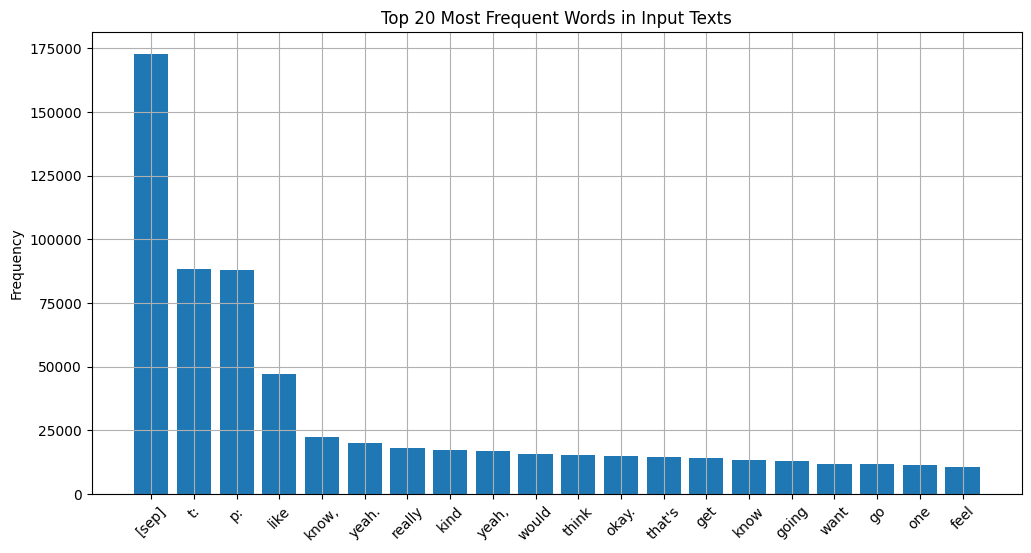

In [7]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Combine all input texts
all_input_texts = " ".join(tokenized_train_dataset['original_input_text'])
words = [word for word in all_input_texts.lower().split() if word not in stop_words]
word_freq = Counter(words).most_common(20)

# Plot
labels, values = zip(*word_freq)
plt.figure(figsize=(12, 6))
plt.bar(labels, values)
plt.title("Top 20 Most Frequent Words in Input Texts")
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [8]:
from random import randint

for _ in range(3):
    idx = randint(0, len(tokenized_train_dataset)-1)
    print(f"\n🔹 Input: {tokenized_train_dataset['original_input_text'][idx]}")
    print(f"🔸 Target: {tokenized_train_dataset['original_target_text'][idx]}")



🔹 Input: p: okay, [sep] t: you're doing okay? [sep] p: yeah [sep] t: i understand your father budget today is a little worried about i might be feeling. [sep] p: yeah. i mean, he's worried that i'm depressed, but i am not. [sep] t: yeah, he had mentioned that you had some concerns about some things going on in a neighborhood and you call the police a few times. [sep] p: he told you that? [sep] t: they told me about that. [sep] p: well, yeah, i mean, i had called i have called the police a few times because there's something going on in my neighborhood. and it's, yeah, makes me seem like i'm depressed but i'm not i just i'm concerned. about what's going on. [sep] t: sure you're not depressed, you're more concerned. so what's going on? we live it's misleading to these feelings. [sep] p: um, well, it's actually very scary, huh. there i know about. the government has been kidnapping girls in this area and taking them away for sex trafficking and prostitution. [sep] t: to boot the governme

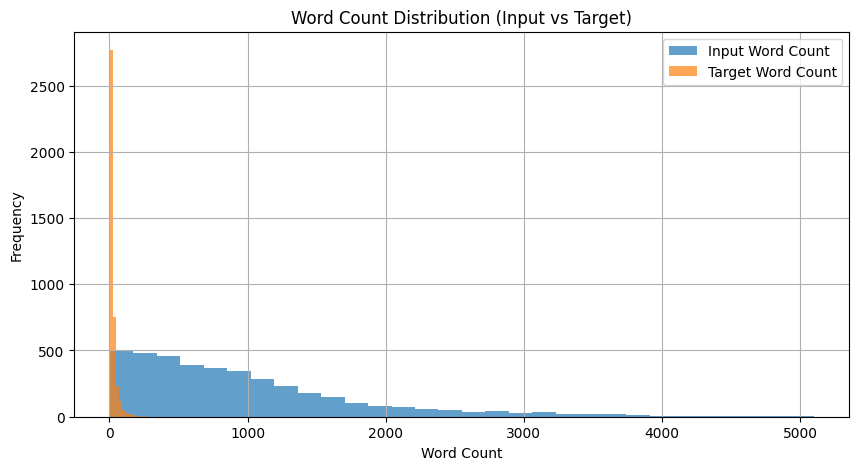

In [9]:
input_word_lengths = [len(text.split()) for text in tokenized_train_dataset['original_input_text']]
target_word_lengths = [len(text.split()) for text in tokenized_train_dataset['original_target_text']]

plt.figure(figsize=(10, 5))
plt.hist(input_word_lengths, bins=30, alpha=0.7, label='Input Word Count')
plt.hist(target_word_lengths, bins=30, alpha=0.7, label='Target Word Count')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution (Input vs Target)")
plt.legend()
plt.grid(True)
plt.show()


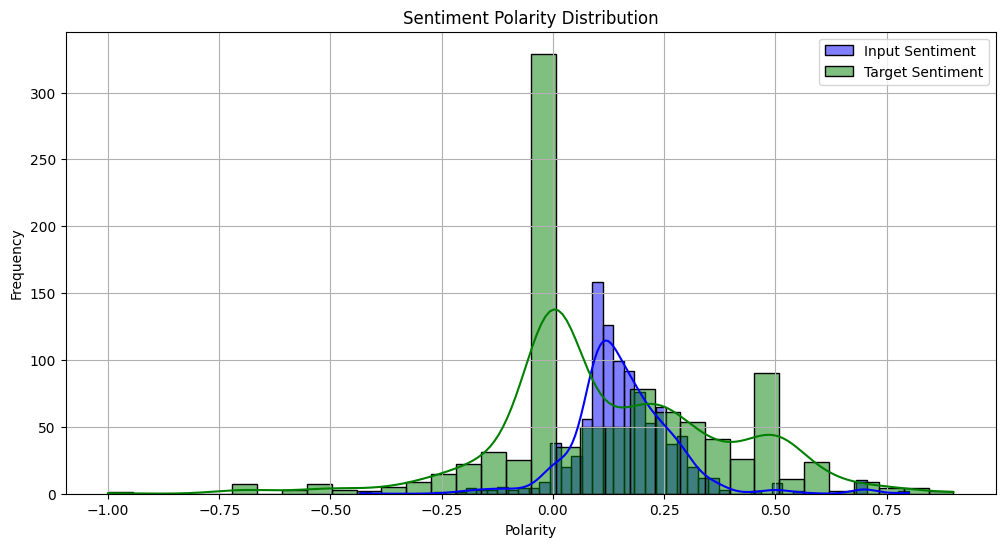

In [12]:
from textblob import TextBlob

def get_sentiment_scores(texts):
    polarity_scores = []
    for text in texts[:1000]:  # sample for speed
        blob = TextBlob(text)
        polarity_scores.append(blob.sentiment.polarity)
    return polarity_scores

input_sentiments = get_sentiment_scores(train_dataset['input_text'])
target_sentiments = get_sentiment_scores(train_dataset['target_text'])

plt.figure(figsize=(12, 6))
sns.histplot(input_sentiments, color='blue', label='Input Sentiment', kde=True)
sns.histplot(target_sentiments, color='green', label='Target Sentiment', kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
from transformers import TrainingArguments
from transformers import T5ForConditionalGeneration, T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained("t5-small")
# tokenizer2 = T5Tokenizer.from_pretrained("t5-small")

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=50,           # Adjust epochs as needed
    per_device_train_batch_size=2, # Adjust batch size based on your GPU
    per_device_eval_batch_size=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=5e-5,
    weight_decay=0.01,
    gradient_accumulation_steps=4,  # Accumulate gradients over 4 steps
    save_total_limit=2,
)

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

from transformers import Trainer

trainer = Trainer(
    model=model,                           # Your pre-trained (or fine-tuned) model.
    args=training_args,                    # The training parameters we set earlier.
    train_dataset=tokenized_train_dataset, # Your training data (tokenized).
    eval_dataset=tokenized_val_dataset,    # Your validation data (tokenized).
    data_collator=data_collator,           # The function to handle padding.
    tokenizer=tokenizer,                   # The tokenizer associated with your model.
)


/mnt/disk1/sumdev/anaconda3/envs/nhai/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_3883504/1457483931.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,2.236500,1.905653
2,1.579700,1.369894
3,1.158100,1.002606
4,0.854600,0.768843
5,0.691100,0.632563
6,0.599600,0.553212
7,0.533700,0.504974
8,0.477500,0.473781
9,0.458000,0.453652
10,0.446000,0.440262


TrainOutput(global_step=25050, training_loss=0.527405755810157, metrics={'train_runtime': 4152.162, 'train_samples_per_second': 48.264, 'train_steps_per_second': 6.033, 'total_flos': 1.35612485074944e+16, 'train_loss': 0.527405755810157, 'epoch': 50.0})

In [10]:
model.save_pretrained("t5-model")
tokenizer.save_pretrained("t5-tokenizer")

('t5-tokenizer/tokenizer_config.json',
 't5-tokenizer/special_tokens_map.json',
 't5-tokenizer/spiece.model',
 't5-tokenizer/added_tokens.json',
 't5-tokenizer/tokenizer.json')

In [11]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_path = "t5-model"
tokenizer_path = "t5-tokenizer"

tokenizer = T5Tokenizer.from_pretrained(tokenizer_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# print("Model and tokenizer loaded successfully.")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [12]:
test_example = tokenized_test_dataset[5]
device = 0
model.to(device)


input_ids = test_example["input_ids"]
input_ids_tensor = torch.tensor([input_ids]).to(device) 

model.eval()


outputs = model.generate(input_ids_tensor, max_length=128)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("input text: ", tokenized_test_dataset[5]["original_input_text"])
print("target text: ", tokenized_test_dataset[5]["original_target_text"])
print("Generated response:", generated_text)

input text:  t: so, alright, let's take a step back and talk about competency. what education did you need for the job you have now? [sep] p: i have my bachelor's degree. and we got a little bit of training. you know every so often we get some training at work and stuff like that. [sep] t: are you evaluated at work by anybody to see if you're in a job you should be? [sep] p: yeah, i have a supervisor so they check up on stuff and also like if i feel like i have questions and stuff like that, i can go to them as well. [sep] t: have you been found in that system to be somebody who's satisfying the requirements of in terms of competency satisfy the requirements of employee. [sep] p: yeah, i mean, i haven't been fired. so that's a good sign again, [sep] t: that's a good sign. yeah, you haven't been fired. have you ever had any type of write up or somebody discussing something with you? [sep] p: no, i just i kind of feel like maybe the climate has changed a little bit at the office after th

In [13]:
test_example = tokenized_test_dataset[3]
device = 0
model.to(device)


input_ids = test_example["input_ids"]
input_ids_tensor = torch.tensor([input_ids]).to(device) 

model.eval()


outputs = model.generate(input_ids_tensor, max_length=128)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("input text: ", tokenized_test_dataset[3]["original_input_text"])
print("target text: ", tokenized_test_dataset[3]["original_target_text"])
print("Generated response:", generated_text)

input text:  t: so, alright, let's take a step back and talk about competency. what education did you need for the job you have now? [sep] p: i have my bachelor's degree. and we got a little bit of training. you know every so often we get some training at work and stuff like that. [sep] t: are you evaluated at work by anybody to see if you're in a job you should be? [sep] p: yeah, i have a supervisor so they check up on stuff and also like if i feel like i have questions and stuff like that, i can go to them as well. [sep] t: have you been found in that system to be somebody who's satisfying the requirements of in terms of competency satisfy the requirements of employee. [sep] p: yeah, i mean, i haven't been fired. so that's a good sign again, [sep] t: that's a good sign. yeah, you haven't been fired. have you ever had any type of write up or somebody discussing something with you? [sep] p: no, i just i kind of feel like maybe the climate has changed a little bit at the office after th

In [14]:
import nltk
import os
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

nltk.download('punkt')
nltk.download('punkt_tab')

nltk_data_path = "/mnt/disk1/sumdev/NHAI_PROJECT/NLP-Project-Akshat/nltk_data"
nltk.data.path.append(nltk_data_path)

try:
    nltk.download('punkt', download_dir=nltk_data_path)
    nltk.download('punkt_tab', download_dir=nltk_data_path)
except Exception as e:
    print(f"Download Error: {e}")

[nltk_data] Downloading package punkt to
[nltk_data]     /mnt/disk1/sumdev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /mnt/disk1/sumdev/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /mnt/disk1/sumdev/NHAI_PROJECT/NLP-Project-
[nltk_data]     Akshat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /mnt/disk1/sumdev/NHAI_PROJECT/NLP-Project-
[nltk_data]     Akshat/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [15]:
# Function to compute BLEU for one pair of reference and candidate sentences
def compute_bleu(reference, candidate):
    smoothie = SmoothingFunction().method4
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)


print(compute_bleu(tokenized_test_dataset[0]["original_target_text"],generated_text))


0.013302246854899122


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

generated_texts = []
for example in tokenized_test_dataset:
    input_ids = torch.tensor([example["input_ids"]]).to(device)
    outputs = model.generate(input_ids, max_length=128)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_texts.append(generated_text)
    
    
references = [example["original_target_text"] for example in tokenized_test_dataset]
from bert_score import score

P, R, F1 = score(generated_texts, references, lang='en', verbose=True)
avg_bert_score = F1.mean().item()
print("Average BERTScore F1:", avg_bert_score)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 17/17 [00:01<00:00,  8.52it/s]


computing greedy matching.


100%|██████████| 16/16 [00:00<00:00, 154.70it/s]

done in 2.11 seconds, 459.59 sentences/sec
Average BERTScore F1: 0.843066394329071


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(reference, candidate):
    smoothie = SmoothingFunction().method4
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    return sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)

def average_bleu(tokenized_test_dataset, generated_texts):
    total_bleu = 0
    n = len(tokenized_test_dataset)

    for i in range(n):
        reference = tokenized_test_dataset[i]["original_target_text"]
        candidate = generated_texts[i]
        bleu_score = compute_bleu(reference, candidate)
        total_bleu += bleu_score

    average_bleu_score = total_bleu / n
    return average_bleu_score

print("Average BLEU Score:", average_bleu(tokenized_test_dataset, generated_texts))

Average BLEU Score: 0.01619490339522764
